In [108]:
from imports import *


# machine learning
from scipy import stats
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score

pd.options.display.max_columns = 100


In [24]:
df = pd.read_csv("cleaned_data/cleaned_wvs_data.csv")

Now, let's train our linear regression, which will proceed in several steps.

1) Feature scaling. We will apply StandardScaler to standardize all numeric features. This is important because variables like "trust" are on a much smaller scale when compared to variables like "GDP". Our research question is about measuring feature importance, which means that in order to compare across features, we need them all to have the same scale.

2) Create polynomial features. This allows the model to capture non-linear relationships. Degree selected through cross-validation. We will grid search over degrees 1 through 3.

3) Model selection. We train two models --- one a standard OLS linear model, and the second a linear regression with LASSO (L1) regularization. The OLS regression will provide a benchmark from which we can compare the improvement from L1 regularization, which performs feature selection. These models were chosen because they both have highly interpretable coefficients. Note: for our project, it does not make sense to perform dimensionality reduction via PCA on all the numerical variables. This is because PCA loses the interpretability that we are interested in, because it would collapse work_ethic, trust, equality, and religion into its principal components, whcih of course prevents us from determining which of these aspects are the most important.

4) Hyperparameter Tuning. Used 10-fold cross-validation with grid search. Tuned polynomial degree (1-3) --- on both models --- and regularization strength (20 values log-spaced from 10^-2 to 10^2) --- on just the LASSO model. Cross-validation prevents overfitting, because it holds out validation data to prevent leakage. Grid search finds optimal complexity. Log-spaced regularization values test different strengths of L1 penalty.

In [28]:
predictors = ["work_ethic", "trust", "equality", "religion", "gdp_per_capita", "hdi"]

X = df[predictors]
y = df["democracy_score"]

In [27]:
"""
Train OLS model
"""

# set up ols pipeline
ols_pipeline = Pipeline(steps=[
   ('scaler', StandardScaler()),
   ('poly', PolynomialFeatures(include_bias=False)),
   ('regressor', LinearRegression())
])

# define ols parameter grid
ols_param_grid = {
    'poly__degree': [1, 2, 3]
}

# set up grid search
ols_cv = GridSearchCV(
    ols_pipeline,
    ols_param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

ols_cv.fit(X, y)


print("OLS Best Parameters:", ols_cv.best_params_)
print("OLS Best Mean Squared Error:", -ols_cv.best_score_)

OLS Best Parameters: {'poly__degree': 1}
OLS Best Mean Squared Error: 2.4784276360931843


In [30]:
"""
Train LASSO Model
"""

seed = 109

# set up lasso pipeline
lasso_pipeline = Pipeline(steps=[
   ('scaler', StandardScaler()),
   ('poly', PolynomialFeatures(include_bias=False)),
   ('regressor', Lasso(random_state = seed, max_iter=10000))
])

# define lasso parameter grid
lasso_param_grid = {
    'poly__degree': [1, 2, 3],
    'regressor__alpha': np.logspace(-2, 2, 20)
}

# set up grid search

lasso_cv = GridSearchCV(
    lasso_pipeline,
    lasso_param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

lasso_cv.fit(X, y)


print("OLS Best Parameters:", lasso_cv.best_params_)
print("OLS Best Mean Squared Error:", -lasso_cv.best_score_)

OLS Best Parameters: {'poly__degree': 2, 'regressor__alpha': np.float64(0.06951927961775606)}
OLS Best Mean Squared Error: 1.8521920749529415


Now, let's begin the analysis and model evaluation. First, here are the coeffficient values for both models.

In [127]:
# get best models / pipelines
best_model_ols = ols_cv.best_estimator_.named_steps['regressor']
best_pipeline_ols = ols_cv.best_estimator_
best_model_lasso = lasso_cv.best_estimator_.named_steps['regressor']
best_pipeline_lasso = lasso_cv.best_estimator_

# get coefficients from best models
ols_intercept = best_model_ols.intercept_
ols_coef = best_model_ols.coef_
ols_coef_full = np.concatenate(([ols_intercept], ols_coef))

lasso_intercept = best_model_lasso.intercept_
lasso_coef = best_model_lasso.coef_
lasso_coef_full = np.concatenate(([lasso_intercept], lasso_coef))

# get feature names for best degree of each model
best_degree_ols = ols_cv.best_params_['poly__degree']
poly_ols = PolynomialFeatures(degree=best_degree_ols, include_bias=False)
feature_names_ols = poly_ols.fit(X).get_feature_names_out(predictors)

best_degree_lasso = lasso_cv.best_params_['poly__degree']
poly_lasso = PolynomialFeatures(degree=best_degree_lasso, include_bias=False)
feature_names_lasso = poly_lasso.fit(X).get_feature_names_out(predictors)

# create results dataframes
ols_results = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names_ols),
    'Coefficient': ols_coef_full
})

lasso_results = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names_lasso),
    'Coefficient': lasso_coef_full
})

# rename features
feature_map = {
    'Intercept': "Intercept",
    'work_ethic': 'Work Ethic',
    'trust': 'Trust',
    'equality': 'Equality',
    'religion': 'Religion',
    'gdp_per_capita': 'GDP per Capita',
    'hdi': 'HDI',
    # squared terms
    'work_ethic^2': 'Work Ethic Squared',
    'trust^2': 'Trust Squared',
    'equality^2': 'Equality Squared',
    'religion^2': 'Religion Squared',
    'gdp_per_capita^2': 'GDP per Capita Squared',
    'hdi^2': 'HDI²',
    # interaction terms
    'work_ethic trust': 'Work Ethic * Trust',
    'work_ethic equality': 'Work Ethic * Equality',
    'work_ethic religion': 'Work Ethic * Religion',
    'work_ethic gdp_per_capita': 'Work Ethic * GDP per Capita',
    'work_ethic hdi': 'Work Ethic * HDI',
    'trust equality': 'Trust * Equality',
    'trust religion': 'Trust * Religion',
    'trust gdp_per_capita': 'Trust * GDP per Capita',
    'trust hdi': 'Trust * HDI',
    'equality religion': 'Equality * Religion',
    'equality gdp_per_capita': 'Equality * GDP per Capita',
    'equality hdi': 'Equality * HDI',
    'religion gdp_per_capita': 'Religion * GDP per Capita',
    'religion hdi': 'Religion * HDI',
    'gdp_per_capita hdi': 'GDP per Capita * HDI'
}

ols_results['Feature'] = ols_results['Feature'].map(feature_map)
lasso_results['Feature'] = lasso_results['Feature'].map(feature_map)

ols_results_sorted = ols_results.sort_values(by='Coefficient', key=abs, ascending=False)
lasso_results_sorted = lasso_results.sort_values(by='Coefficient', key=abs, ascending=False)

print("OLS Coefficients")
display(ols_results_sorted)

print("LASSO Coefficients")
display(lasso_results_sorted)

OLS Coefficients


,Feature,Coefficient
0,Intercept,5.853801
3,Equality,0.907350
6,HDI,0.742764
2,Trust,0.319375
1,Work Ethic,-0.154907
5,GDP per Capita,-0.102566
4,Religion,0.038507


LASSO Coefficients


,Feature,Coefficient
0,Intercept,5.647716
6,HDI,0.967781
3,Equality,0.813410
17,Trust * HDI,-0.338083
24,Religion * HDI,-0.318144
21,Equality * HDI,0.248425
23,Religion * GDP per Capita,-0.222131
12,Work Ethic * HDI,-0.153673
22,Religion Squared,-0.085459
25,GDP per Capita Squared,-0.070675


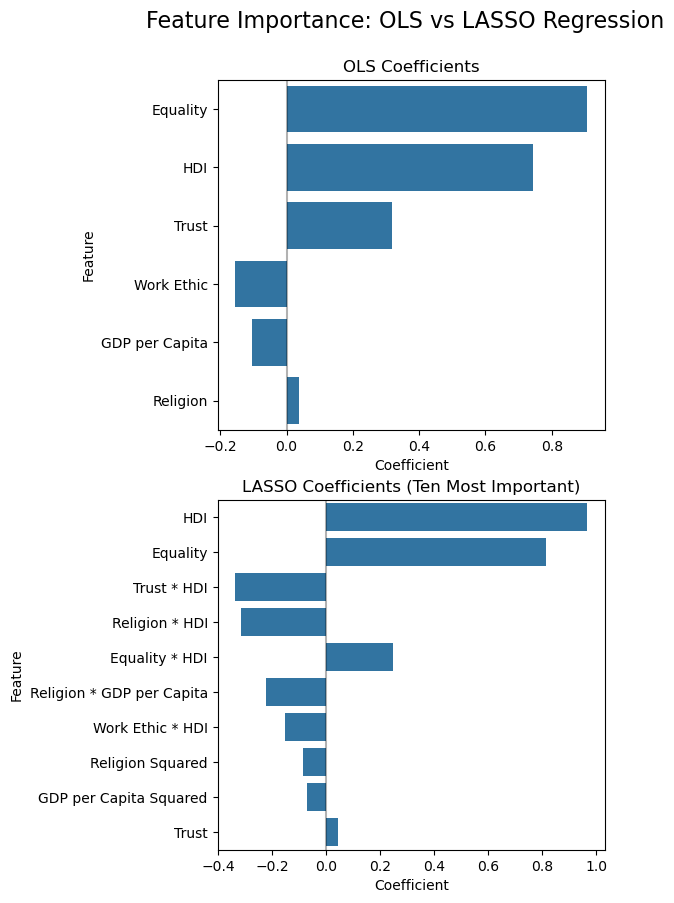

In [129]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
fig.suptitle('Feature Importance: OLS vs LASSO Regression', fontsize=16, y=0.95)

axes = axes.flatten()

# create OLS plot
sns.barplot(data=ols_results_sorted[1:], y='Feature', x='Coefficient', ax=axes[0], orient='h')
axes[0].set_title(f'OLS Coefficients')
axes[0].axvline(0, color='black', alpha=0.3)

sns.barplot(data=lasso_results_sorted[1:11], y='Feature', x='Coefficient', ax=axes[1], orient='h')
axes[1].set_title(f'LASSO Coefficients (Ten Most Important)')
axes[1].axvline(0, color='black', alpha=0.3)


Now, let's calculate the standard errors for each of the two models. We will compute the analytic confidence intervals for the OLS model. We will compute the bootstrapped confidence intervals for the LASSO model --- only for non-zero coefficients, i.e. coefficients that have already been selected.

In [106]:
"""
Get OLS analytic confidence intervals
"""
X_ols = poly_ols.fit_transform(X)
n_ols, p_ols = X_ols.shape
y_pred_ols =  best_pipeline_ols.predict(X_ols)
residuals_ols = y - y_pred_ols

# estimate variance of the error term
s2 = np.sum(residuals_ols ** 2) / (n_ols - p_ols - 1)

# calculate standard errors
X_design_ols = np.hstack([np.ones((n_ols, 1)), X_ols])  # add intercept
se_ols = np.sqrt(s2 * np.diag(np.linalg.inv(X_design_ols.T @ X_design_ols)))

# calculate confidence intervals
z_crit = 1.96
ci_lower_ols = ols_coef_full - z_crit * se_ols
ci_upper_ols = ols_coef_full + z_crit * se_ols

# add to OLS results dataframe
ols_results['SE'] = se_ols
ols_results['CI_Lower'] = ci_lower_ols
ols_results['CI_Upper'] = ci_upper_ols

/Users/julienberman/micromamba/envs/cs109a-project/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [126]:
def bootstrap(X, y, pipeline, n_bootstraps=1000):
    """
    Performs bootstrap resampling and returns coefficient estimates for each bootstrap sample.
    - returns an array of shape (n_bootstraps, n_features + 1) containing coefficient estimates for each bootstrap sample, including intercept
    """
    bootstrap_coefs = []
    
    for i in range(n_bootstraps):
        # generate bootstrap sample
        X_bootstrap, y_bootstrap = resample(X, y, random_state=i)
        
        # fit pipeline on bootstrap sample
        pipeline_boot = clone(pipeline)
        pipeline_boot.fit(X_bootstrap, y_bootstrap)
                
        # get coefficients. includes intercept.
        coef_boot = np.concatenate([[pipeline_boot.named_steps['regressor'].intercept_], pipeline_boot.named_steps['regressor'].coef_])
        
        bootstrap_coefs.append(coef_boot)
    
    return np.array(bootstrap_coefs)

In [141]:
"""
Get LASSO confidence intervals via bootstrap
"""
# get bootstrapped coefficients
lasso_coef_bootstrap = bootstrap(X, y, best_pipeline_lasso)
bootstrap_distributions = [lasso_coef_bootstrap[:, i] for i in range(lasso_coef_bootstrap.shape[1])]

# calculate standard errors
se_lasso = np.std(lasso_coef_bootstrap, axis=0)

# calculate bootstrapped confidence intervals
ci_lower_lasso = lasso_coef_full - z_crit * se_lasso
ci_upper_lasso = lasso_coef_full + z_crit * se_lasso

# add to LASSO results dataframe
lasso_results['SE'] = se_lasso
lasso_results['CI_Lower'] = ci_lower_lasso
lasso_results['CI_Upper'] = ci_upper_lasso
lasso_results['Bootstrap'] = bootstrap_distributions

Here are visualizations of the distributions for the bootstrapped LASSO coefficients, along with the bootstrapped confidence intervals. I only included the ten most significant features.

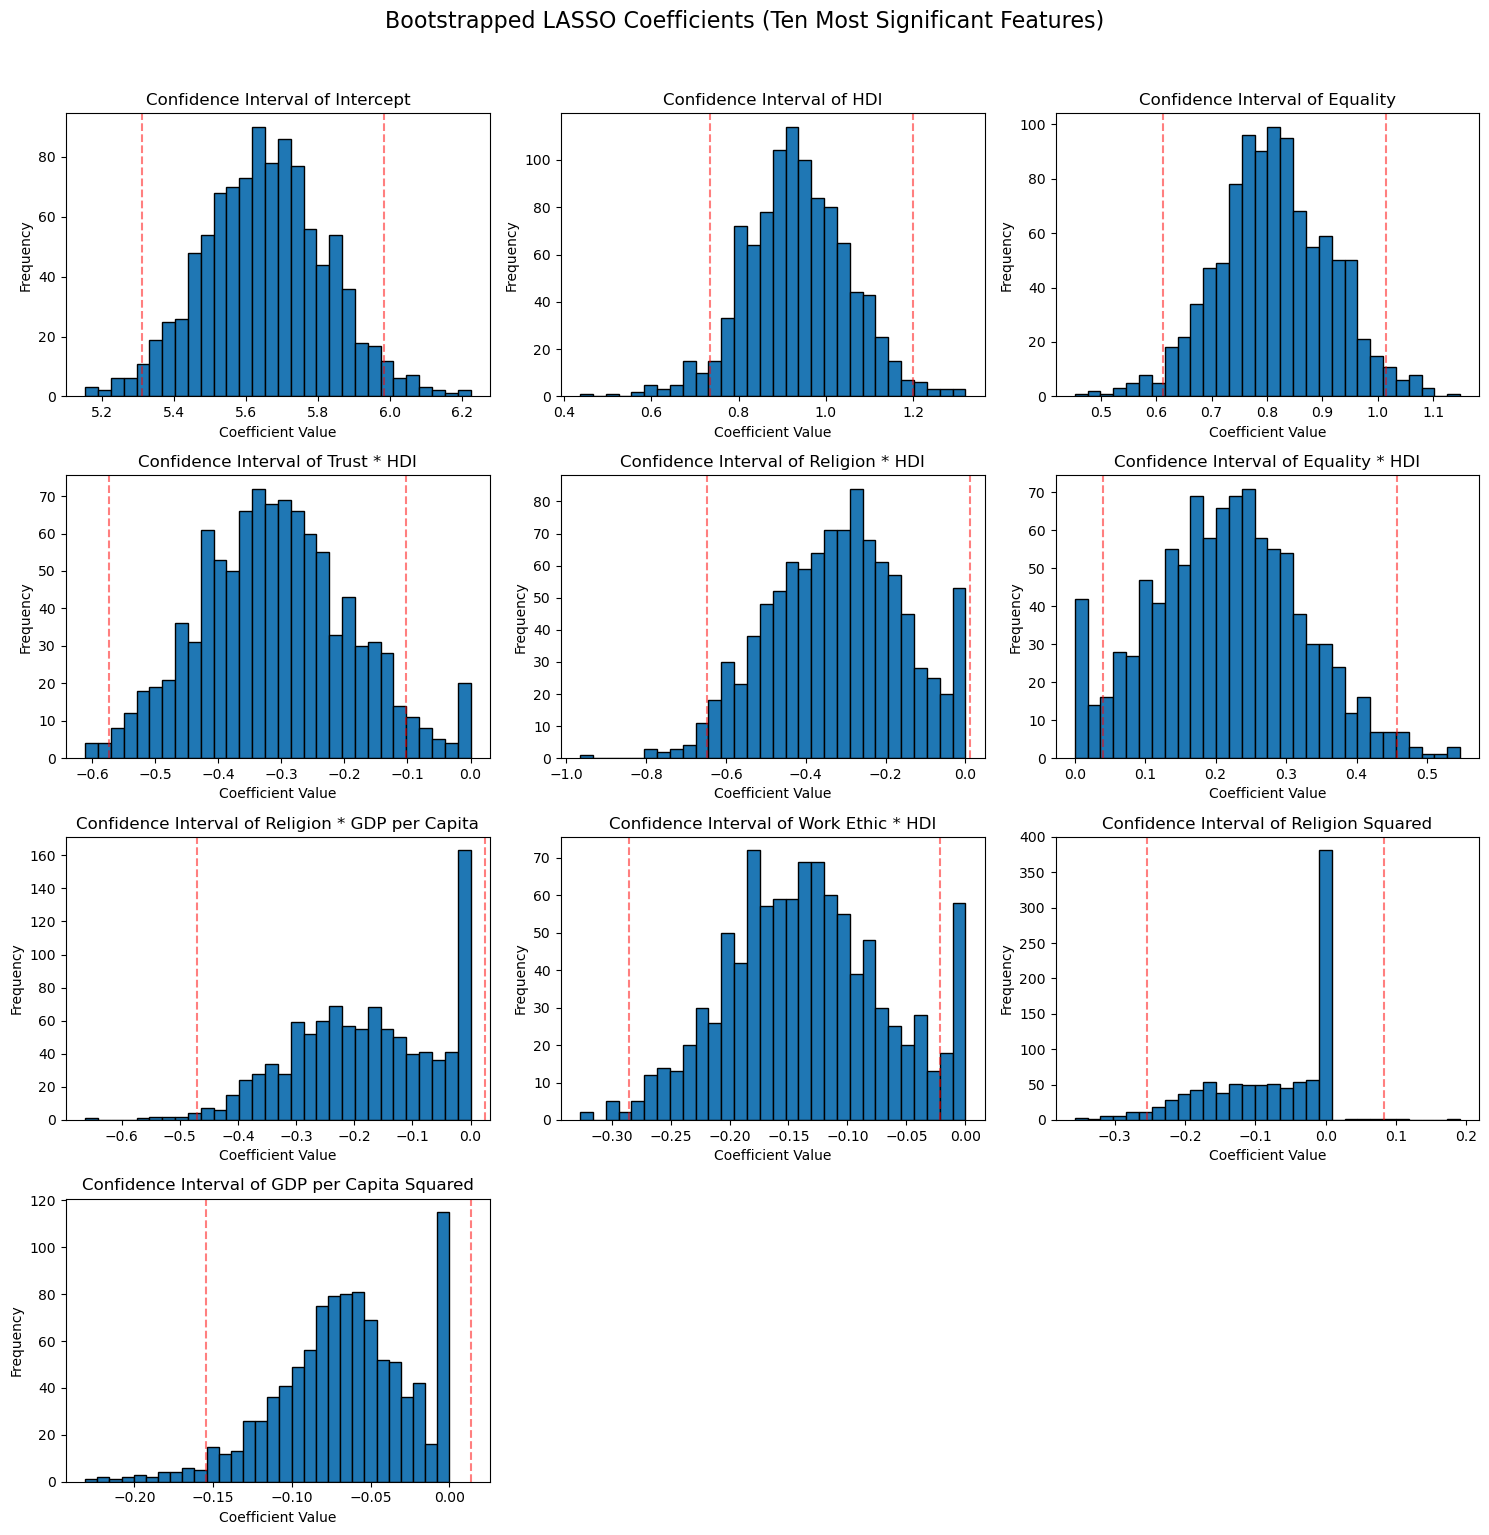

In [146]:
top_10_features = lasso_results.sort_values(by='Coefficient', key=abs, ascending=False).iloc[:(10)]

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
fig.suptitle('Bootstrapped LASSO Coefficients (Ten Most Significant Features)', fontsize=16, y=1.02)
axes = axes.flatten()

# plot histograms for each feature
for i, (idx, row) in enumerate(top_10_features.iterrows()):
    feature = row['Feature']
    ci_lower = row['CI_Lower']
    ci_upper = row['CI_Upper']
    coef_dist = row["Bootstrap"]  
      
    # Create histogram
    axes[i].hist(coef_dist, bins=30, edgecolor='black')
    
    # Add vertical lines for confidence intervals
    axes[i].axvline(x=ci_lower, color='r', linestyle='--', alpha=0.5)
    axes[i].axvline(x=ci_upper, color='r', linestyle='--', alpha=0.5)
    
    # Add title and labels
    axes[i].set_title(f'Confidence Interval of {feature}')
    axes[i].set_xlabel('Coefficient Value')
    axes[i].set_ylabel('Frequency')

# Hide empty subplots
for i in range(len(top_10_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Here is a figure that shows the mean squared for the different L1 penalties, and why we chose the penalty size that we did.

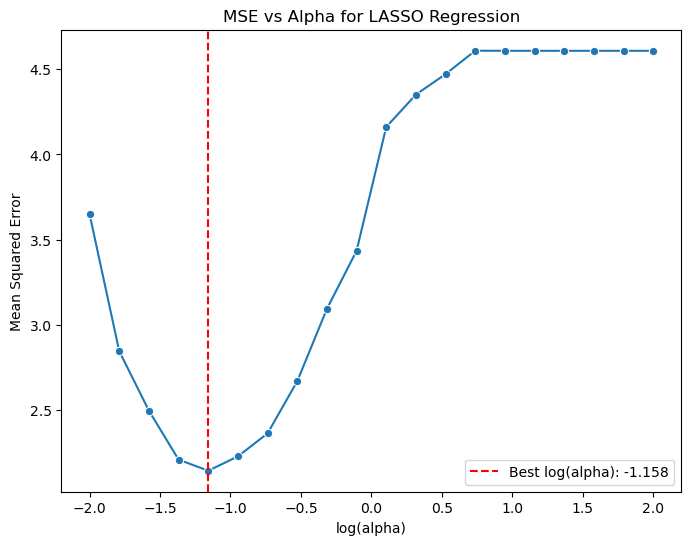

In [159]:
# get alphas and MSE scores from LASSO grid search results
alphas = lasso_cv.cv_results_['param_regressor__alpha'].data.astype(float)
mse_scores = -lasso_cv.cv_results_['mean_test_score']  # negative because we used neg_mean_squared_error
best_alpha = lasso_cv.best_params_['regressor__alpha']

# create plot
plt.figure(figsize=(8, 6))
sns.lineplot(x=np.log10(alphas), y=mse_scores, marker = 'o', errorbar=None)
plt.axvline(x=np.log10(best_alpha), color='r', linestyle='--', label=f'Best log(alpha): {np.log10(best_alpha):.3f}')
plt.xlabel('log(alpha)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha for LASSO Regression')
plt.legend()
plt.show()